# Building Demand Method 1 Simplified

#### Brief overview:

The energy demand for each cell is assessed according to the following parameters:
𝐵 Number of buildings
𝑆𝑟𝑒𝑠 Share of res buildings
𝑁 Nb of HH per res buildings
𝑎 Electrified status (probability)
𝐸_𝐻𝐻  Energy consumption per HH
𝑟 Adjustment with RWI

For each cell c, we have 𝐷_𝑐=𝐵_𝑐∗𝑆𝑟𝑒𝑠∗𝑁_𝑐  ∗𝑎_𝑐  ∗𝐸_𝐻𝐻  ∗𝑟_𝑐 

### Import necessary modules

In [1]:
# Check if we are running the notebook directly, if so move workspace to parent dir
import sys
import os
currentdir = os.path.abspath(os.getcwd())
if os.path.basename(currentdir) != 'DemandMappingZambia':  
  sys.path.insert(0, os.path.dirname(currentdir))
  os.chdir('..')
  print(f'Move to {os.getcwd()}')

Move to C:\Users\amillot\PycharmProjects\DemandMappingZambia


In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
import ogr, gdal, osr
#import fiona

# Mapping / Plotting
from functools import reduce
#import datapane as dp 
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
# %matplotlib inline

In [3]:
#import geopandas as gpd   # Note that you require geopandas version >= 0.7 that incluse clip see here for installation (https://gis.stackexchange.com/questions/360127/geopandas-0-6-1-installed-instead-of-0-7-0-in-conda-windows-10#)
import os
import fiona
import ipywidgets as widgets
from IPython.display import display
from rasterstats import zonal_stats
import rasterio
from geojson import Feature, Point, FeatureCollection
import rasterio.fill
from shapely.geometry import shape, mapping
import json
#from earthpy import clip    clip has been deprecated to geopandas
#import earthpy.spatial as es
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
import gdal
import datetime
import warnings
import pandas as pd
import scipy.spatial
warnings.filterwarnings('ignore')

#import contextily as ctx
import h3 as h3
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

pd.options.display.float_format = '{:,.2f}'.format

In [4]:
from utils import processing_raster, finalizing_rasters

### Define directories and dataset names

In [5]:
### Define directories and dataset names

ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR
out_path = ROOT_DIR + "/Outputs"


In [6]:
## RWI layer
rwi_path = in_path + "/Residential/Data/WealthIndex"
rwi_name = 'zmb_relative_wealth_index.csv'

In [7]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

### Define area of interest

In [8]:
try: area
except NameError: area = "COUNTRY"
# area = "Copperbelt"

In [9]:
## Regions list
regions_path = "admin/"
regions_list = 'Regions_list.csv'
df_regions = pd.read_csv(regions_path + regions_list)
regions = df_regions['Regions GADM']
if area != "COUNTRY":
    regions = [area]
regions

0       Copperbelt
1         Muchinga
2    North-Western
3          Western
4          Luapula
5         Northern
6          Central
7         Southern
8          Eastern
9           Lusaka
Name: Regions GADM, dtype: object

### Import layers to be used

In [10]:
## Import Relative Wealth Index | convert to geodf | export as gpkg
rwi = pd.read_csv(rwi_path + "/" + rwi_name)
rwi_gdf = gpd.GeoDataFrame(rwi, geometry=gpd.points_from_xy(rwi.longitude, rwi.latitude), crs={'init': 'epsg:4326'})
rwi_gdf.to_file(os.path.join(rwi_path,"{c}".format(c=rwi_name.split(".")[0])), driver="GPKG")

In [11]:
hexagons = gpd.read_file(out_path + "\\" + "h3_grid_at_hex_7.shp")

In [12]:
grid = hexagons

In [13]:
grid

,hexagons,lon,lat,index_righ,NAME_1,id,geometry
0,87344d185ffffff,27.26,-15.29,0.00,Central,1,"POLYGON ((27.27072 -15.29349, 27.26042 -15.303..."
1,875511689ffffff,22.96,-14.19,9.00,Western,2,"POLYGON ((22.96827 -14.19496, 22.95822 -14.204..."
2,87344aa90ffffff,26.30,-17.36,8.00,Southern,3,"POLYGON ((26.31695 -17.36887, 26.30648 -17.378..."
3,87346b014ffffff,28.30,-14.98,0.00,Central,4,"POLYGON ((28.30962 -14.98378, 28.29933 -14.993..."
4,8739b3ce6ffffff,31.20,-12.25,5.00,Muchinga,5,"POLYGON ((31.21713 -12.25920, 31.20711 -12.269..."
...,...,...,...,...,...,...,...
122983,873986952ffffff,32.06,-10.79,5.00,Muchinga,122984,"POLYGON ((32.07165 -10.79077, 32.06182 -10.801..."
122984,875510d1effffff,24.66,-14.99,9.00,Western,122985,"POLYGON ((24.66961 -14.99830, 24.65942 -15.008..."
122985,87346892effffff,29.96,-14.30,0.00,Central,122986,"POLYGON ((29.97482 -14.30232, 29.96458 -14.312..."
122986,8755303b5ffffff,26.56,-12.93,6.00,North-Western,122987,"POLYGON ((26.57678 -12.93635, 26.56672 -12.946..."


## Extract raster values to hexagons

Extract count of buildings per hex from WorldPop

In [14]:
pathWorldPopBuiCount = "Residential/Data/WorldPop/ZMB_buildings_v2_0_count.tif"
# grid = processing_raster("buildings", "count", grid, filepath=pathWorldPopBuiCount)
grid = processing_raster("buildings", "sum", grid, filepath=pathWorldPopBuiCount) #Copperbelt_buildings_v2_0_count from https://apps.worldpop.org/peanutButter/
# pathWorldPopBuiArea = "Residential/Data/WorldPop/Copperbelt_buildings_v2_0_total_area.tif"
# grid = processing_raster("bui_area_WP", "sum", grid, filepath=pathWorldPopBuiArea) #Copperbelt_buildings_v2_0_count from https://apps.worldpop.org/peanutButter/

2024-04-29 11:16:32.169564


Extract urban areas from WorldPop

In [15]:
pathWorldPopBuiUrban = "Residential/Data/WorldPop/ZMB_buildings_v2_0_urban.tif"
grid = processing_raster("locationWP", "median", grid, filepath=pathWorldPopBuiUrban)      #Copperbelt_population_v1_0_gridded from https://apps.worldpop.org/peanutButter/

2024-04-29 11:32:21.925287


Extract lighing data

In [16]:
## set_lightscore_sy_xxxx.tif: Predicted likelihood that a settlement is electrified (0 to 1)
## http://www-personal.umich.edu/~brianmin/HREA/data.html
# pathHREA = "Residential/Data/Lighting/Copperbelt_set_lightscore_sy_2019_Nodata_values_fixed.tif"
pathHREA = "Residential/Data/Lighting/Zambia_set_lightscore_sy_2019.tif"
grid = processing_raster("HREA", "mean", grid, filepath=pathHREA)
probElec= "HREA"

2024-04-29 13:18:11.669977


Extract RWI

In [17]:
# Relative Wealth Index (RWI) -- extracting the mean value per building
# Link: https://gee-community-catalog.org/projects/rwi/
pathRWI = "Residential/Data/WealthIndex/rwi_map.tif"
grid = processing_raster("rwi", "mean", grid, filepath=pathRWI)

2024-04-29 13:30:04.482081


Extract tiers Falchetta dataset

In [18]:
# extract tiers share from Falchetta dataset #https://www.nature.com/articles/s41597-019-0122-6#Sec7
pathElecAccess = "Residential/Data/Falchetta_ElecAccess/Zambia_tiersofaccess_2018.tif"
grid = processing_raster("tiers", "majority", grid, filepath=pathElecAccess)

2024-04-29 13:43:52.782015


Extract GDP Kummu dataset 

In [19]:
#Link https://www.nature.com/articles/sdata20184#Sec9
pathGDP = "Residential/Data/GDP/GDP_PPP_30arcsec_v3_band3_Zambia.tif"
grid = processing_raster("GDP_PPP", "mean", grid, filepath=pathGDP)

2024-04-29 13:57:38.567079


##### Once done with rasters run this cell

In [20]:
grid = finalizing_rasters(out_path, grid, crs_proj)

2024-04-29 13:58:57.798066


In [21]:
grid.rename({'HREAmean': 'HREA'}, axis=1, inplace=True)
grid.rename({'rwimean': 'rwi'}, axis=1, inplace=True)
grid.rename({'locationWPmedian': 'locationWP'}, axis=1, inplace=True)
grid.rename({'tiersmajority': 'tiers'}, axis=1, inplace=True)
grid.rename({'GDP_PPPmean': 'GDP_PPP'}, axis=1, inplace=True)

Add values in RWI column when there is none

In [22]:
grid["rwi"].fillna(grid["rwi"].mean(numeric_only=True).round(1), inplace=True)
print(grid["rwi"].min())
print(grid["rwi"].max())

-1.2319999933242798
1.496250033378601


In [23]:
grid.head(3)

,hexagons,lon,lat,index_righ,NAME_1,id,buildingssum,locationWP,HREA,rwi,tiers,GDP_PPP,geometry
0,87344d185ffffff,27.26,-15.29,0.00,Central,1,42.00,0.00,0.11,-0.59,0.00,NaN,"POLYGON ((27.27072 -15.29349, 27.26042 -15.303..."
1,875511689ffffff,22.96,-14.19,9.00,Western,2,121.00,0.00,0.03,-0.43,0.00,NaN,"POLYGON ((22.96827 -14.19496, 22.95822 -14.204..."
2,87344aa90ffffff,26.30,-17.36,8.00,Southern,3,NaN,NaN,0.16,-0.40,0.00,NaN,"POLYGON ((26.31695 -17.36887, 26.30648 -17.378..."


## Extract residential demand from UN stats

In [24]:
# Residential energy demand at the country level
energyBalance_path = "EnergyBalance/"
file_energyBalance = "UNSD+DF_UNData_EnergyBalance+1.0_Zambia.csv"
eb = pd.read_csv(energyBalance_path + file_energyBalance)
code_elec = "B07_EL"
code_hh =  "B50_1231"
total_residentialenergy_TJ = eb.loc[(eb['COMMODITY'] == code_elec) & (eb['TRANSACTION'] == code_hh) & (eb['TIME_PERIOD'] == 2019 ), 'OBS_VALUE'] #TJ
total_residentialenergy_TJ = pd.to_numeric(total_residentialenergy_TJ.str.replace(',', '')) # convert to numeric and remove commas
total_residentialenergy_GWh = total_residentialenergy_TJ.iloc[0]/3.6 # conversion in GWh
print("Residential electricity consumption", total_residentialenergy_GWh, "GWh")

Residential electricity consumption 4022.5 GWh


### Step 1: assess the number of HH with access

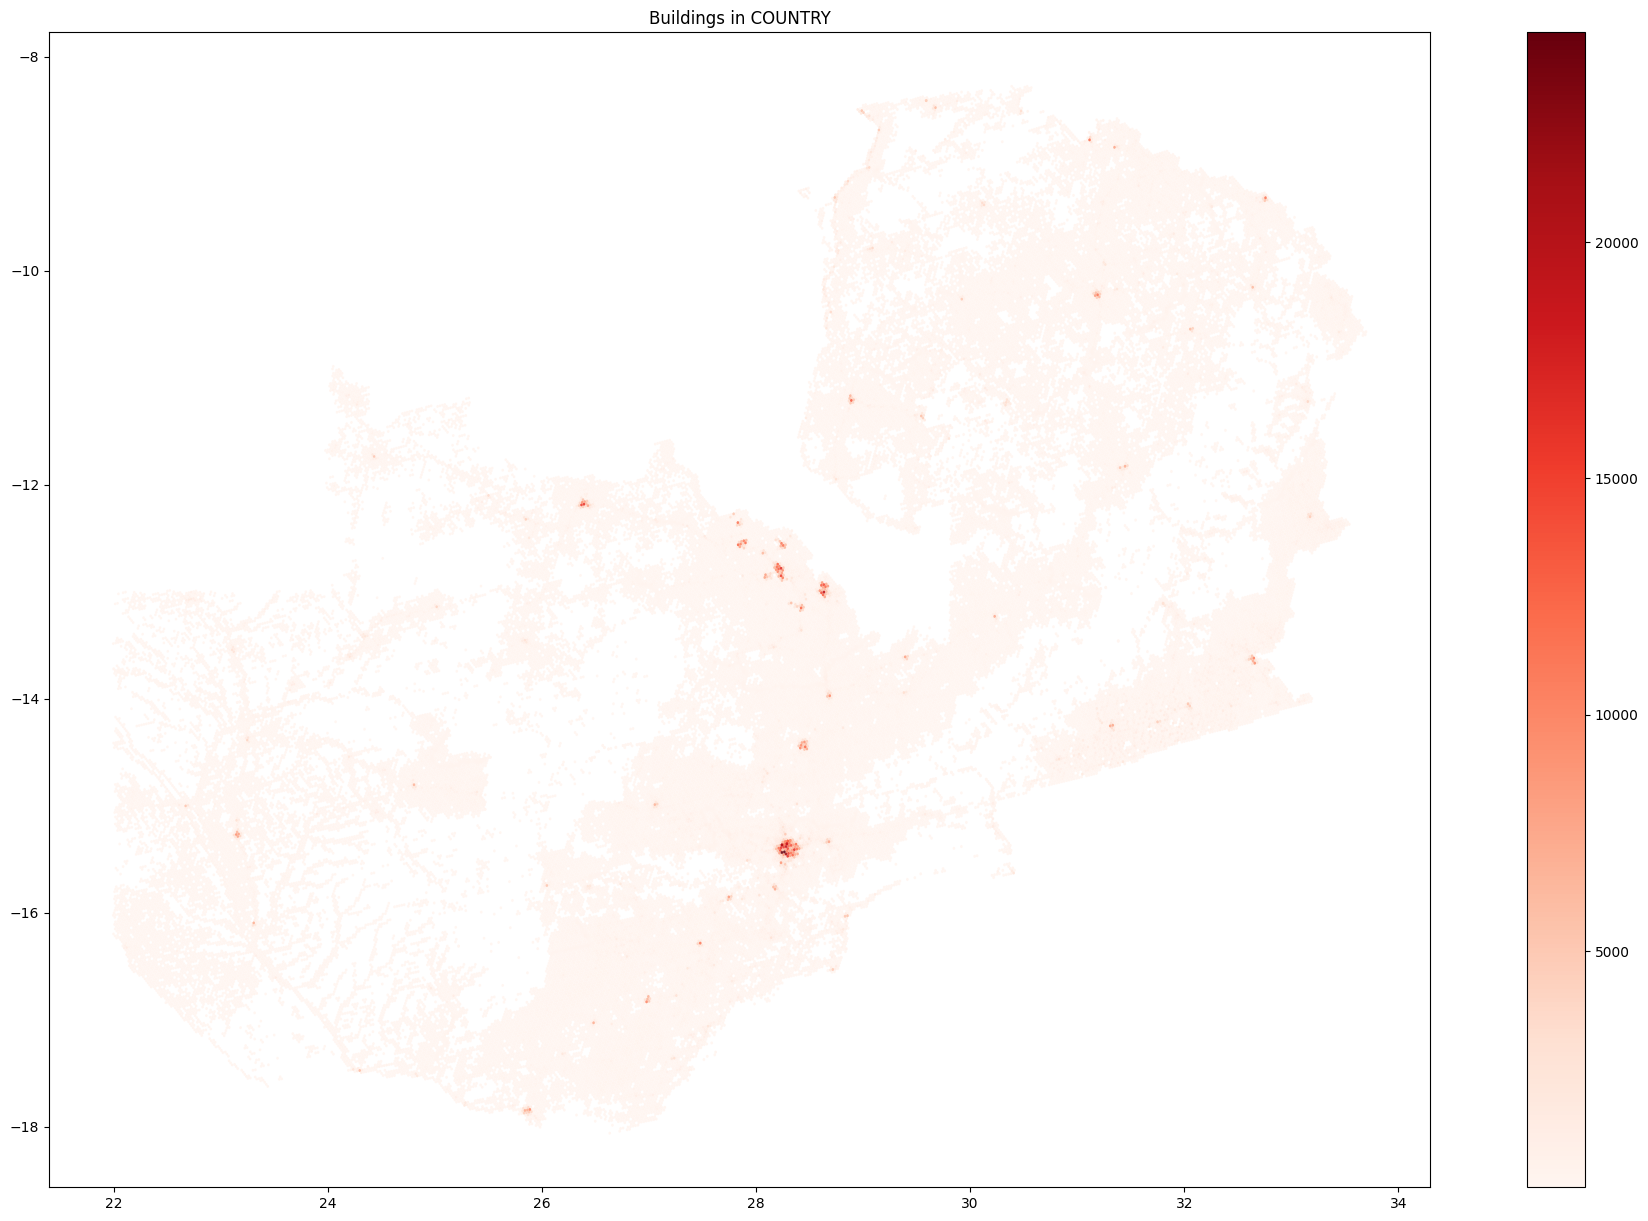

In [25]:
# Plot the buildings map
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot data
grid.sort_values('buildingssum', ascending=True).plot(
    ax=ax, column='buildingssum', cmap="Reds", legend=True, alpha=0.9)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Buildings in {}'.format(area) )

# # Save plot as figure 
# plt.savefig('sample_priority_map.png', bbox_inches='tight')

Determine electrifed status of each cell

In [26]:
# electrified or non-electrified status
grid["Status_electrified"] = grid.apply(lambda row: ("elec" if ((row[probElec] > 0.25))
                                             else "nonelec"), axis=1)
grid["Status_electrified"].value_counts()

Status_electrified
nonelec    109649
elec        13339
Name: count, dtype: int64

Determine location (ruban or rural) of each cell

In [27]:
# for each hexagon, determine if it's rural or urban --> choose best source
# grid["locAssessed"] = grid.apply(lambda row: ("urban" if ((row['buildingssum'] > 1000)) # number chosen to get 1 for nb of HH per rural building
#                                              else "rural"), axis=1)
grid["locWorldPop"] = grid.apply(lambda row: ("urban" if ((row['locationWP'] == 1)) 
                                             else "rural"), axis=1)
# grid["locGHSL"] = grid.apply (lambda row: ("urban" if ((row['SMOD'] == 30) or (row['SMOD'] == 21) or (row['SMOD'] == 22) or (row['SMOD' ] == 23)) 
#                                              else "rural"), axis=1)
grid["location"] = grid["locWorldPop"] 

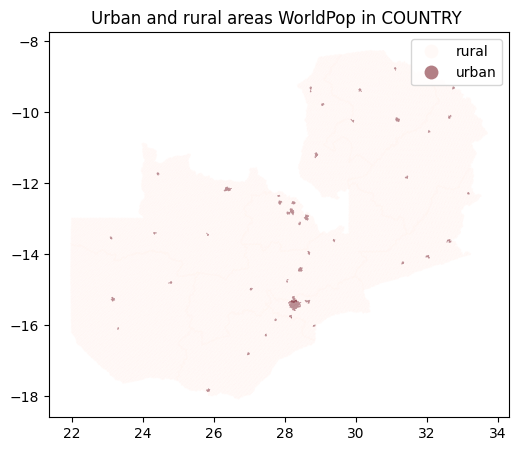

In [28]:
# map of the urban and rural areas WorldPop
# Create the axis first
fig2, ax2 = plt.subplots(figsize=(10, 5))
# Plot
grid.sort_values('locWorldPop', ascending=True).plot(
    ax=ax2, column='locWorldPop', cmap="Reds", legend=True, alpha=0.5)

ax2.set_aspect('equal', 'box')
txt = ax2.set_title('Urban and rural areas WorldPop in {} '.format(area))

Assess number of residential households per cell

In [29]:
# Load data into Pandas DataFrame
## Census data
data_path = "Residential/Data/"
census_name = 'Census_Zambia.csv'
df_censusdata = pd.read_csv(data_path + census_name)

# Create a new dataframe that will contain the regional data
data_HH = df_censusdata[['Region', 'Urban', 'Rural']]
data_HH = data_HH.rename({'Region':'region','Urban':'HH_urban', 'Rural':'HH_rural'}, axis = 1)
data_HH = data_HH.set_index(['region'])
data_HH['HH_total'] = data_HH['HH_urban'] + data_HH['HH_rural']
data_HH = data_HH.astype(float)

In [30]:
# Option 1: use buildings count from Worldpop to assess number of buildings
# total number of buildings
data_buildings = []
for region in regions:
    totalBuildings = grid[(grid['NAME_1'] == region)]['buildingssum'].sum()
    urbanBuildings = grid[(grid['location'] == "urban") & (grid['NAME_1'] == region)]['buildingssum'].sum()
    ruralBuildings = grid[(grid['location'] == "rural") & (grid['NAME_1'] == region)]['buildingssum'].sum()
    data_region = {
        'region': region,
        'totalBuildings': totalBuildings,
        'urbanBuildings': urbanBuildings,
        'ruralBuildings': ruralBuildings,
        'shareRuralBuild': ruralBuildings / totalBuildings,
        'shareUrbanBuild': urbanBuildings / totalBuildings,
    }
    data_buildings.append(data_region)
    # print("total Buildings in",f"{region}",f"{totalBuildings:,.0f}", "urban:",f"{urbanBuildings:,.0f}", "rural:",f"{ruralBuildings:,.0f}")
    # print("share Build urban:", f"{data_region['shareUrbanBuild']:.0%}","rural:",f"{data_region['shareRuralBuild']:.0%}")

df_buildings = pd.DataFrame(data_buildings)
df_buildings = df_buildings.set_index('region')
# df_buildings
df_HH_buildings = data_HH.merge(df_buildings, left_on='region', right_on='region')
df_HH_buildings

,HH_urban,HH_rural,HH_total,totalBuildings,urbanBuildings,ruralBuildings,shareRuralBuild,shareUrbanBuild
region,,,,,,,,
Copperbelt,"449,077.00","85,356.00","534,433.00","1,117,170.00","604,165.00","513,005.00",0.46,0.54
Muchinga,"24,953.00","151,730.00","176,683.00","623,493.00","80,335.00","543,158.00",0.87,0.13
North-Western,"91,501.00","116,233.00","207,734.00","576,163.00","151,021.00","425,142.00",0.74,0.26
Western,"54,466.00","205,604.00","260,070.00","796,764.00","80,858.00","715,906.00",0.90,0.10
Luapula,"44,689.00","228,300.00","272,989.00","615,968.00","84,579.00","531,389.00",0.86,0.14
Northern,"72,867.00","230,684.00","303,551.00","823,956.00","104,365.00","719,591.00",0.87,0.13
Central,"98,493.00","292,947.00","391,440.00","1,533,577.00","321,668.00","1,211,909.00",0.79,0.21
Southern,"120,410.00","316,294.00","436,704.00","1,359,567.00","132,997.00","1,226,570.00",0.90,0.10
Eastern,"82,166.00","369,725.00","451,891.00","1,359,153.00","119,052.00","1,240,101.00",0.91,0.09


Assess number of residential buildings

In [31]:
# share of residential building in each location --> not used because we use the assumption of nb of HH per res bui but can be used if we have data on share of residential building
# shareResBuildings = {"urban": 0.5, "rural": 0.15} # --> to change! # number chosen to get 1 for nb of HH per rural building, and for urban twice the value in rural
# resUrbanBuildings = urbanBuildings*shareResBuildings["urban"]
# resRuralBuildings = ruralBuildings*shareResBuildings["rural"]
# resTotalBuildings = resUrbanBuildings + resRuralBuildings

# Assess the number of residential HH per building
nbOfHHperResBuilding =  {"urban": 1.2, "rural": 1}  # --> to update depending on the country
# nbOfHHperResBuilding["urban"]= HH_urban/resUrbanBuildings --> use if the main assumption is on the share of res buildings
# nbOfHHperResBuilding["rural"]= HH_rural/resRuralBuildings --> use if the main assumption is on the share of res buildings

# Assess the number of residential buildings
df_HH_buildings['shareUrbanResBui'] = df_HH_buildings['HH_urban'] /(nbOfHHperResBuilding["urban"]* df_HH_buildings['urbanBuildings'])
df_HH_buildings['shareRuralResBui'] = df_HH_buildings['HH_rural'] /(nbOfHHperResBuilding["rural"]* df_HH_buildings['ruralBuildings'])
df_HH_buildings['resUrbanBui'] = df_HH_buildings['urbanBuildings'] * df_HH_buildings['shareUrbanResBui']
df_HH_buildings['resRuralBui'] = df_HH_buildings['ruralBuildings'] * df_HH_buildings['shareRuralResBui']
df_HH_buildings['resTotalBui'] = df_HH_buildings['resUrbanBui'] + df_HH_buildings['resRuralBui']

# Check: Assess the total number of HH in the region (should match the census data)
totalResHHurban = nbOfHHperResBuilding["urban"]*df_HH_buildings['resUrbanBui']
# print(totalResHHurban)
# print(df_HH_buildings['HH_urban'])
# assert totalResHHurban.equals(df_HH_buildings['HH_urban'])
totalResHHrural = nbOfHHperResBuilding["rural"]*df_HH_buildings['resRuralBui']
# assert totalResHHrural.equals(df_HH_buildings['HH_rural'])

# Number of HH per res buildings in each region average
df_HH_buildings['nbOfHHperResBui_average'] = df_HH_buildings['HH_total'] / (df_HH_buildings['urbanBuildings']*df_HH_buildings['shareUrbanResBui'] +
                                                                 df_HH_buildings['ruralBuildings'] * df_HH_buildings['shareRuralResBui'])

# df_HH_buildings

In [32]:
# Assess the number of HH per cell
grid['res_urbanBui'] = grid['buildingssum'] * (grid['location'] == 'urban') * grid['NAME_1'].map(df_HH_buildings['shareUrbanResBui'])
grid['res_ruralBui'] = grid['buildingssum'] * (grid['location'] == 'rural') * grid['NAME_1'].map(df_HH_buildings['shareRuralResBui'])
grid['res_Bui'] = grid['res_urbanBui'] + grid['res_ruralBui']
grid['HH_urban'] = grid['res_urbanBui'] * nbOfHHperResBuilding['urban']
grid['HH_rural'] = grid['res_ruralBui'] * nbOfHHperResBuilding['rural']
grid['HH_total'] = grid['HH_rural'] + grid['HH_urban']

Assess number of residential households per cell with access to electricity

In [33]:
# for each hexagon, assessment of the number of HH with access
# access_elec = {"elec": 0, "nonelec": 1}
grid["HHwithAccess_urb"] = grid['HH_urban'] * grid[probElec]
grid["HHwithAccess_rur"] = grid['HH_rural'] * grid[probElec]                                        
grid["HHwithAccess"] = grid["HHwithAccess_urb"] + grid["HHwithAccess_rur"]

grid['HHwoAccess_urb'] = grid['HH_urban'] - grid['HHwithAccess_urb']
grid['HHwoAccess_rur'] = grid['HH_rural'] - grid['HHwithAccess_rur']
grid['HHwoAccess'] = grid['HHwoAccess_urb'] + grid['HHwoAccess_rur']

totalHHWithAccessUrb = grid.groupby('NAME_1')['HHwithAccess_urb'].sum()
totalHHWithAccessRur = grid.groupby('NAME_1')['HHwithAccess_rur'].sum()
totalHHWithAccess = grid.groupby('NAME_1')['HHwithAccess'].sum()

df_HH_access = pd.concat([totalHHWithAccessUrb, totalHHWithAccessRur, totalHHWithAccess], axis=1)
df_HH_access.rename_axis('region', inplace=True)
df_HH_buildings = df_HH_buildings.merge(df_HH_access, left_on='region', right_on='region')
# df_HH_buildings

Compute the resulting access rate

In [34]:
# access rate for HH
df_HH_buildings['accessRateHH'] = df_HH_buildings['HHwithAccess']/df_HH_buildings['HH_total']
df_HH_buildings['accessRateHH_urban'] = df_HH_buildings['HHwithAccess_urb']/df_HH_buildings['HH_urban']
df_HH_buildings['accessRateHH_rural'] = df_HH_buildings['HHwithAccess_rur']/df_HH_buildings['HH_rural']

# access rate for population
# accessRatePop = (totalHHWithAccessUrb*pplperHH_urban+totalHHWithAccessRur*pplperHH_rural)/totalPopStats
# accessRatePop_urban = totalHHWithAccessUrb*pplperHH_urban/totalPop_urban
# accessRatePop_rural = totalHHWithAccessRur*pplperHH_rural/totalPop_rural
# print("Pop access rate :",f"{accessRatePop:,.0%}")
# print("Pop access rate urban:",f"{accessRatePop_urban:,.0%}")
# print("Pop access rate rural:",f"{accessRatePop_rural:,.0%}")

df_HH_buildings.to_csv("dataHH_region.csv")
df_HH_buildings

,HH_urban,HH_rural,HH_total,totalBuildings,urbanBuildings,ruralBuildings,shareRuralBuild,shareUrbanBuild,shareUrbanResBui,shareRuralResBui,resUrbanBui,resRuralBui,resTotalBui,nbOfHHperResBui_average,HHwithAccess_urb,HHwithAccess_rur,HHwithAccess,accessRateHH,accessRateHH_urban,accessRateHH_rural
region,,,,,,,,,,,,,,,,,,,,
Copperbelt,"449,077.00","85,356.00","534,433.00","1,117,170.00","604,165.00","513,005.00",0.46,0.54,0.62,0.17,"374,230.83","85,356.00","459,586.83",1.16,"449,039.15","47,966.88","497,006.02",0.93,1.00,0.56
Muchinga,"24,953.00","151,730.00","176,683.00","623,493.00","80,335.00","543,158.00",0.87,0.13,0.26,0.28,"20,794.17","151,730.00","172,524.17",1.02,"24,106.09","26,797.45","50,903.54",0.29,0.97,0.18
North-Western,"91,501.00","116,233.00","207,734.00","576,163.00","151,021.00","425,142.00",0.74,0.26,0.50,0.27,"76,250.83","116,233.00","192,483.83",1.08,"85,893.45","26,516.50","112,409.95",0.54,0.94,0.23
Western,"54,466.00","205,604.00","260,070.00","796,764.00","80,858.00","715,906.00",0.90,0.10,0.56,0.29,"45,388.33","205,604.00","250,992.33",1.04,"52,924.54","34,547.53","87,472.08",0.34,0.97,0.17
Luapula,"44,689.00","228,300.00","272,989.00","615,968.00","84,579.00","531,389.00",0.86,0.14,0.44,0.43,"37,240.83","228,300.00","265,540.83",1.03,"42,625.72","80,023.36","122,649.08",0.45,0.95,0.35
Northern,"72,867.00","230,684.00","303,551.00","823,956.00","104,365.00","719,591.00",0.87,0.13,0.58,0.32,"60,722.50","230,684.00","291,406.50",1.04,"69,798.46","49,049.04","118,847.50",0.39,0.96,0.21
Central,"98,493.00","292,947.00","391,440.00","1,533,577.00","321,668.00","1,211,909.00",0.79,0.21,0.26,0.24,"82,077.50","292,947.00","375,024.50",1.04,"97,553.30","72,684.12","170,237.42",0.43,0.99,0.25
Southern,"120,410.00","316,294.00","436,704.00","1,359,567.00","132,997.00","1,226,570.00",0.90,0.10,0.75,0.26,"100,341.67","316,294.00","416,635.67",1.05,"120,120.16","71,579.06","191,699.22",0.44,1.00,0.23
Eastern,"82,166.00","369,725.00","451,891.00","1,359,153.00","119,052.00","1,240,101.00",0.91,0.09,0.58,0.30,"68,471.67","369,725.00","438,196.67",1.03,"79,746.06","66,116.82","145,862.88",0.32,0.97,0.18


### Step 2: assess the energy consumption per HH

#### Method 1: create an index based on rwi and HREA

In [35]:
# # Retrieve values from the MTF survey # not used because it leads to an overassessment of energy
# %run Residential/energy_demand_res.ipynb
# energyConsHH = energycons_res_mtf["annual"] # dictionnary for each region one value
# energyConsHH['COPPERBELT']=1250
# energyConsHH

In [36]:
# function for allocate tier of energy consumption to an index
def index_to_energy(index, table_index):
    energy = 0
    for key, val in table_index:
        if index < key:
            break
        else: energy = val
    return energy

# data for energy consumption tiers
file_HHenergycons = "HH_energyconsumption.csv"
HHenergycons = pd.read_csv(data_path + file_HHenergycons)
thresholds_energy = HHenergycons.iloc[0].tolist() # thresholds_energy  = [5, 73, 365, 1250, 3012]
print(HHenergycons)

   Tier 1  Tier 2  Tier 3  Tier 4  Tier 5
0       8     200     778    2224    4656


##### Index only based on rwi

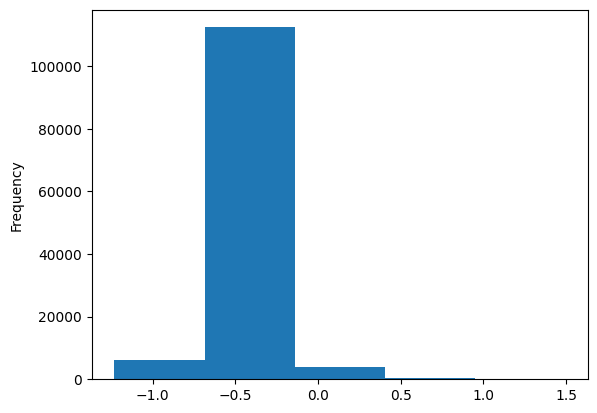

[(-1.2319999933242798, 8), (-0.6863499879837036, 200), (-0.14069998264312744, 778), (0.40495002269744873, 2224), (0.9506000280380249, 4656)]


In [37]:
# Method 1.1: allocate directly rwi to energy consumption
grid['rwi'].plot.hist(bins=5)
plt.show()
thresholds_rwi = (grid['rwi'].max()-grid['rwi'].min())/5*np.arange(5)+grid['rwi'].min()
table_rwi = list(zip(thresholds_rwi, thresholds_energy))
print(table_rwi)
grid['ResEnergyPerHH_rwi'] = grid['rwi'].apply(lambda rwi: index_to_energy(rwi,table_rwi))

Index only based on rwi and HREA

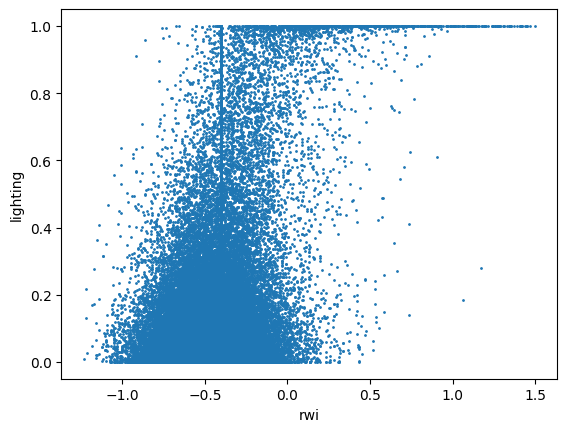

In [38]:
# Link between rwi and HREA
plt.scatter(grid['rwi'], grid['HREA'],s=1)

# Add labels to the plot
plt.xlabel('rwi')
plt.ylabel('lighting')

# Set the axis to logarithmic scale
# plt.yscale('log')
# plt.xscale('log')

# Show the plot
plt.show()

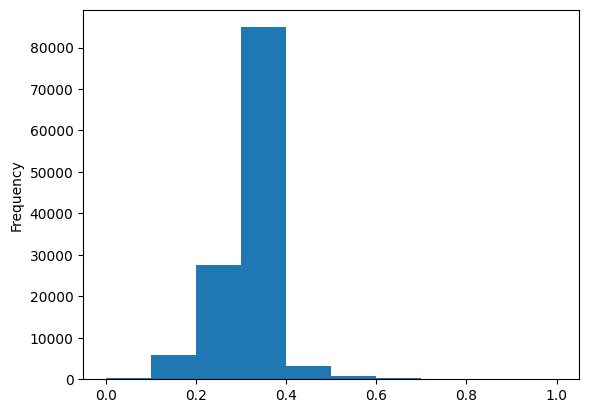

In [39]:
# Normalise the rwi index
rwi_min = grid['rwi'].min()
rwi_max = grid['rwi'].max()
grid['rwi_norm'] = (grid['rwi'] - rwi_min) / (rwi_max - rwi_min)
grid['rwi_norm'].plot.hist()
plt.show()

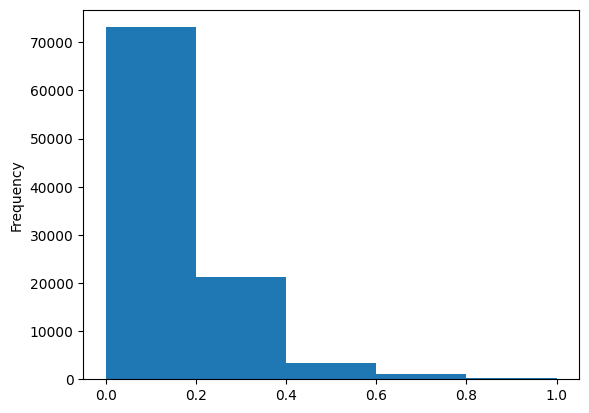

In [40]:
# Method 1.2: create an index combining rwi and HREA: geometric mean 
grid['index'] = np.power(grid['rwi_norm'] * grid['HREA'], 0.5)
grid['index'].plot.hist(bins=5)
thresholds_index = (grid['index'].max()-grid['index'].min())/5*np.arange(5)+grid['index'].min()
table_index = list(zip(thresholds_index, thresholds_energy))
plt.show()

ResEnergyPerHH_index
8       73106
4656    24006
200     21287
778      3411
2224     1178
Name: count, dtype: int64


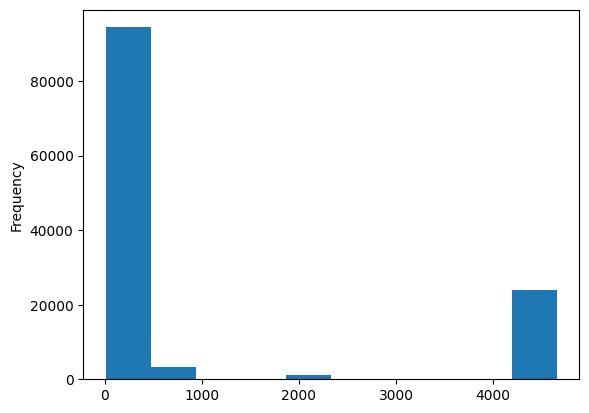

In [41]:
# allocate the energy consumption tier to the index
grid['ResEnergyPerHH_index'] = grid['index'].apply(lambda index: index_to_energy(index,table_index))
grid['ResEnergyPerHH_index'].plot.hist()
print(grid['ResEnergyPerHH_index'].value_counts())
plt.show()

In [42]:
# Assess the shares of tier
tier_share = grid.groupby('ResEnergyPerHH_index')['HHwithAccess'].sum()
tier_share.loc[0] = grid['HHwoAccess'].sum()
# print(tier_share)
print(tier_share/tier_share.sum())
# urban shares
tier_urban_share = grid.groupby('ResEnergyPerHH_index')['HHwithAccess_urb'].sum()
tier_urban_share.loc[0] = grid['HHwoAccess_urb'].sum()
print(tier_urban_share/tier_urban_share.sum())
# rural shares
tier_rural_share = grid.groupby('ResEnergyPerHH_index')['HHwithAccess_rur'].sum() 
tier_rural_share.loc[0] = grid['HHwoAccess_rur'].sum()
print(tier_rural_share/tier_rural_share.sum())

ResEnergyPerHH_index
8      0.02
200    0.04
778    0.05
2224   0.16
4656   0.29
0      0.43
Name: HHwithAccess, dtype: float64
ResEnergyPerHH_index
8      0.00
200    0.00
778    0.02
2224   0.29
4656   0.68
0      0.01
Name: HHwithAccess_urb, dtype: float64
ResEnergyPerHH_index
8      0.04
200    0.07
778    0.07
2224   0.07
4656   0.01
0      0.75
Name: HHwithAccess_rur, dtype: float64


#### Method 2: link the energy consumption with rwi through a logistic function

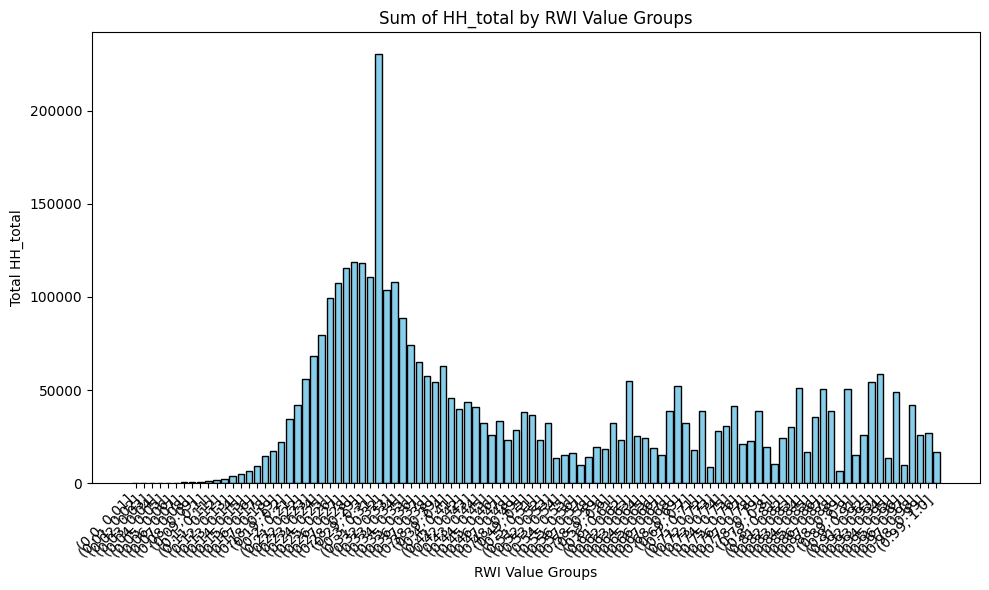

In [43]:
# Plot of number of HH vs rwi

# Create equally spaced bins for the 'rwi' values
num_groups = 100
min_rwi = grid['rwi_norm'].min()
max_rwi = grid['rwi_norm'].max()
bin_width = (max_rwi - min_rwi) / num_groups
bins = [min_rwi + i * bin_width for i in range(num_groups + 1)]

# Group by the bins and sum the 'HH_total' values
grid['rwi_group'] = pd.cut(grid['rwi_norm'], bins)
result = grid.groupby('rwi_group')['HH_total'].sum()
result.index = result.index.astype(str)
# # Print the result
# print(result)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(result.index, result.values, color='skyblue', edgecolor='black')
plt.xlabel('RWI Value Groups')
plt.ylabel('Total HH_total')
plt.title('Sum of HH_total by RWI Value Groups')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

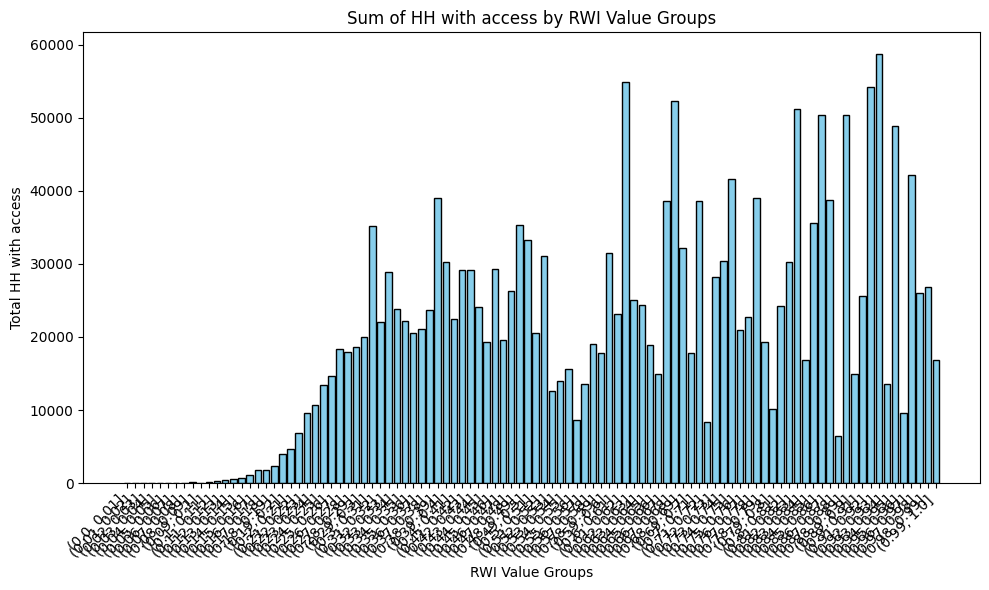

In [44]:
# Plot of number of HH with access vs rwi

# Group by the bins and sum the 'HHwithAccess' values
result = grid.groupby('rwi_group')['HHwithAccess'].sum()
result.index = result.index.astype(str)
# # Print the result
# print(result)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(result.index, result.values, color='skyblue', edgecolor='black')
plt.xlabel('RWI Value Groups')
plt.ylabel('Total HH with access')
plt.title('Sum of HH with access by RWI Value Groups')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [45]:
# solve the equation so that the energy consumption per HH matches total energy demand
from scipy.optimize import fsolve

# variable for the relatioship between rwi and E
E_threshold = 3100
alpha = E_threshold / 4.5 - 1  # alpha set so that E_HH = 4.5 kWh for the lowest tier

def func(x):
    e_hh = E_threshold / (1 + alpha * np.exp(-x  * grid['rwi_norm']))
    res_energy_assessed = e_hh * grid ['HHwithAccess']
    return res_energy_assessed.sum()/10**6- total_residentialenergy_GWh

# Use scipy to solve the equation to find k
k_initial_guess = 2
k_solution = fsolve(func, k_initial_guess)
print(k_solution)


[12.02213713]


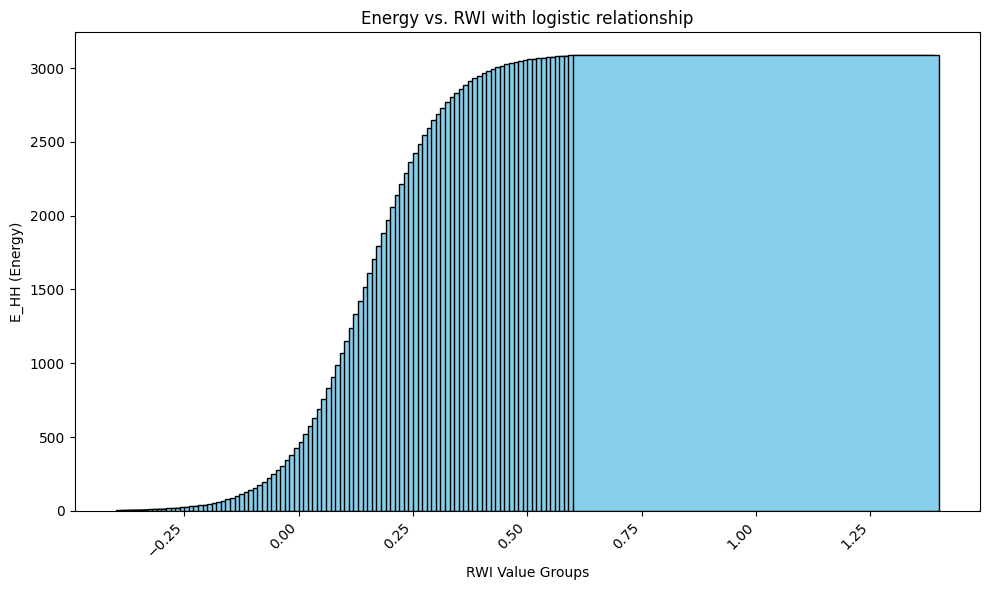

In [46]:
# create the curve linking energy consumption per HH and rwi
rwi_values = bins # Your rwi value groups
# E_threshold = 3100
# alpha = E_threshold / 4.5 - 1  # alpha set so that E_HH = 4.5 kWh for the lowest tier
k = k_solution  # Adjust this constant for the desired curve steepness
E_HH_values = E_threshold / (1 + alpha * np.exp(-k * np.array(rwi_values)))
# print(E_threshold / (1 + alpha * np.exp(-k  * 0)))
# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(rwi_values, E_HH_values, color='skyblue', edgecolor='black')
plt.xlabel('RWI Value Groups')
plt.ylabel('E_HH (Energy)')
plt.title('Energy vs. RWI with logistic relationship')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

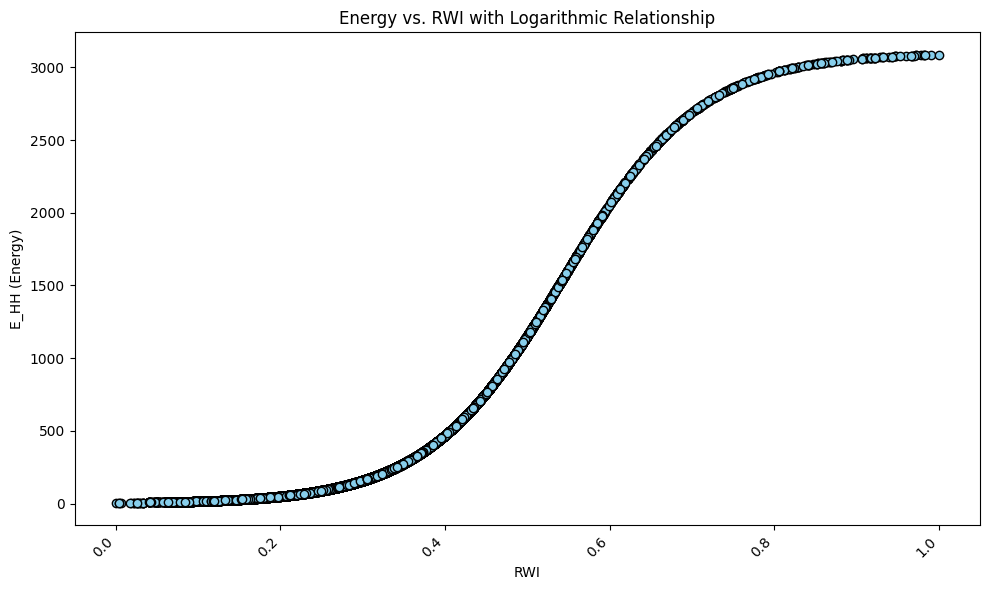

In [47]:
# check that total energy assessed matches the statistics
grid['ResEnergyPerHH_log'] = E_threshold / (1 + alpha * np.exp(-k * grid['rwi_norm']))

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.scatter(grid['rwi_norm'], grid['ResEnergyPerHH_log'], color='skyblue', edgecolor='black')
plt.xlabel('RWI')
plt.ylabel('E_HH (Energy)')
plt.title('Energy vs. RWI with Logarithmic Relationship')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [48]:
# Assess the tier shares 

# Create bins
bins = [0, 5, 72.9, 364.9, 1250.4, 3012.2]
labels = ['1', '2', '3', '4', '5']

# Add a new column with bin labels
grid['bin_labels'] = pd.cut(grid['ResEnergyPerHH_log'], bins=bins, labels=labels)

tier_share = grid.groupby('bin_labels')['HHwithAccess'].sum()
tier_share.loc[0] = grid['HHwoAccess'].sum()
# print(tier_share)
print(tier_share/tier_share.sum())
# urban shares
tier_urban_share = grid.groupby('bin_labels')['HHwithAccess_urb'].sum()
tier_urban_share.loc[0] = grid['HHwoAccess_urb'].sum()
print(tier_urban_share/tier_urban_share.sum())
# rural shares
tier_rural_share = grid.groupby('bin_labels')['HHwithAccess_rur'].sum() 
tier_rural_share.loc[0] = grid['HHwoAccess_rur'].sum()
print(tier_rural_share/tier_rural_share.sum())

bin_labels
1   0.00
2   0.01
3   0.09
4   0.12
5   0.27
0   0.51
Name: HHwithAccess, dtype: float64
bin_labels
1   0.00
2   0.00
3   0.03
4   0.20
5   0.75
0   0.02
Name: HHwithAccess_urb, dtype: float64
bin_labels
1   0.00
2   0.02
3   0.13
4   0.08
5   0.03
0   0.75
Name: HHwithAccess_rur, dtype: float64


#### Method 3: use data coming from the DHS survey

In [81]:
# load data file --> to transform into calling the related script
dataDHS_file = 'dataDHS_group.csv'
data_path = 'Residential/Data/DHSSurvey/'
dataDHS = pd.read_csv(data_path + dataDHS_file)

# interpolation of data
for loc in ['urban', 'rural']:
    column_name = 'HHwithAccess_' + loc[:3]
    include = (grid[column_name]>0)
    rwi_group = dataDHS['rwi_group_' + loc]
    eu_group = dataDHS['eu_group_' + loc]
    grid.loc[include, 'ResEnergyPerHH_DHS'] = np.interp(grid['rwi'][include],rwi_group,eu_group)

### Comparison to Falchetta dataset

In [50]:
# print(grid['tiersmajority'])
tier_share = grid.groupby('tiers')['HHwithAccess'].sum()
tier_share.loc[0] = grid['HHwoAccess'].sum()
# print(tier_share)
print(tier_share/tier_share.sum())
# urban shares
tier_urban_share = grid.groupby('tiers')['HHwithAccess_urb'].sum()
tier_urban_share.loc[0] = grid['HHwoAccess_urb'].sum()
print(tier_urban_share/tier_urban_share.sum())
# rural shares
tier_rural_share = grid.groupby('tiers')['HHwithAccess_rur'].sum() 
tier_rural_share.loc[0] = grid['HHwoAccess_rur'].sum()
print(tier_rural_share/tier_rural_share.sum())

tiers
0.00   0.50
1.00   0.00
2.00   0.01
3.00   0.01
4.00   0.48
Name: HHwithAccess, dtype: float64
tiers
0.00   0.01
1.00   0.00
2.00   0.01
3.00   0.01
4.00   0.96
Name: HHwithAccess_urb, dtype: float64
tiers
0.00   0.94
1.00   0.00
2.00   0.01
3.00   0.01
4.00   0.05
Name: HHwithAccess_rur, dtype: float64


### Step 3: assess energy consumption per cell

In [51]:
# Assess the energy Consumption assessment per cell
averageRwi = grid['rwi'].mean()
weightedRwi_norm = grid['rwi_norm'] * (grid ['HH_urban'] + grid ['HH_rural'])
averageRwi_norm = weightedRwi_norm.sum()/ (grid ['HH_urban'].sum() + grid ['HH_rural'].sum())
print(averageRwi_norm)

# grid["ResEnergyPerHH"] = abs(grid['rwi']/averageRwi)*grid["ADM1_NAME"].map(energyConsHH)

grid["ResEnergyPerHH_meth11a"] = grid['ResEnergyPerHH_rwi']*abs(grid['rwi']/averageRwi)
grid["ResEnergyPerHH_meth11b"] = grid['ResEnergyPerHH_rwi']
grid["ResEnergyPerHH_meth12a"] = grid['ResEnergyPerHH_index']*abs(grid['rwi_norm']/averageRwi_norm)
grid["ResEnergyPerHH_meth12b"] = grid['ResEnergyPerHH_index']
grid["ResEnergyPerHH_meth2"] = grid['ResEnergyPerHH_log']
grid["ResEnergyPerHH_meth3"] = grid['ResEnergyPerHH_DHS']


0.48611337015275885


In [52]:
methods = ['meth11a', 'meth11b', 'meth12a', 'meth12b', 'meth2', 'meth3']
result_beforescaling = pd.DataFrame()
result_afterscaling = pd.DataFrame()
for method in methods:
    grid["ResEnergy_kWh_" + method] = grid["HHwithAccess"] * grid["ResEnergyPerHH_" + method]
    result_beforescaling[method] = grid.groupby('NAME_1')['ResEnergy_kWh_' + method].sum() / 10**6 # conversion in GWh
    total_residentialenergy_assessed = result_beforescaling[method].sum() #res_energy_assessed 
    scaling_factor = total_residentialenergy_GWh/total_residentialenergy_assessed
    result_afterscaling[method] = result_beforescaling[method] * scaling_factor
result_beforescaling

# result = pd.DataFrame.from_dict(result_beforescaling)

,meth11a,meth11b,meth12a,meth12b,meth2,meth3
NAME_1,,,,,,
Central,601.32,284.56,592.52,411.22,246.16,253.74
Copperbelt,"3,549.74","1,531.75","3,246.02","2,033.50","1,286.65","1,424.93"
Eastern,123.96,111.66,304.62,257.57,148.89,131.64
Luapula,24.55,55.23,151.39,166.41,73.13,38.76
Lusaka,"5,543.28","1,993.28","4,023.82","2,313.50","1,494.23","1,880.75"
Muchinga,18.20,26.46,70.58,69.54,39.39,30.18
North-Western,294.75,183.02,454.56,331.19,199.27,191.61
Northern,148.88,115.12,287.70,238.15,130.89,115.49
Southern,459.13,298.33,674.47,497.12,319.28,283.42


In [53]:
result_beforescaling.sum(axis=0)

meth11a   10,827.59
meth11b    4,668.71
meth12a    9,993.44
meth12b    6,486.95
meth2      4,022.50
meth3      4,422.40
dtype: float64

In [54]:
result_afterscaling

,meth11a,meth11b,meth12a,meth12b,meth2,meth3
NAME_1,,,,,,
Central,223.39,245.17,238.50,255.00,246.16,230.80
Copperbelt,"1,318.74","1,319.73","1,306.57","1,260.95","1,286.65","1,296.08"
Eastern,46.05,96.20,122.61,159.72,148.89,119.73
Luapula,9.12,47.58,60.94,103.19,73.13,35.25
Lusaka,"2,059.35","1,717.39","1,619.64","1,434.58","1,494.23","1,710.68"
Muchinga,6.76,22.80,28.41,43.12,39.39,27.45
North-Western,109.50,157.69,182.97,205.37,199.27,174.28
Northern,55.31,99.18,115.80,147.67,130.89,105.04
Southern,170.57,257.04,271.49,308.26,319.28,257.79


In [55]:
# # assess total residential energy consumption
# total_residentialenergy_assessed = grid["ResEnergy_kWh"].sum()
# print("residential electricity consumption:", f"{total_residentialenergy_assessed/10**6:,.0f}","GWh") # GWh
# total_residentialenergy_assessed = total_residentialenergy_assessed/10**6  # conversion in GWh

### Scale residential demand results

Get the electricity consumption at the national level for HH

In [56]:
print("residential electricity consumption UN STATS:", f"{total_residentialenergy_GWh:,.0f}", "GWh")
# print("residential electricity consumption assessed:", f"{total_residentialenergy_assessed:,.0f}", "GWh")

residential electricity consumption UN STATS: 4,022 GWh


Compute total electricity consumption

In [57]:
# total_residentialenergy_beforescaled = grid.groupby('NAME_1')['ResEnergy_kWh'].sum() #res_energy_assessed ResEnergy_kWh
# print ("Residential electricity consumption assessed before scaling:")
# for region in regions:
#     total_residentialenergy_beforescaled[region] = total_residentialenergy_beforescaled[region]/10**6  # conversion in GWh
#     print (region, f"{total_residentialenergy_beforescaled[region]:,.1f}", "GWh" )
# print (total_residentialenergy_beforescaled )

In [58]:
# # Scale previous results if area is country
# scaling_factor = total_residentialenergy/total_residentialenergy_assessed
# grid["ResEnergy_kWh"] = grid['ResEnergyPerHH_DHS']
# if area == "COUNTRY":
#     print('{:.0%}'.format(scaling_factor))
#     grid["REnS_kWh"] = grid["ResEnergy_kWh"] * scaling_factor
# else:
#     grid["REnS_kWh"] = grid["ResEnergy_kWh"]

In [59]:
# total_residentialenergy_scaled = grid.groupby('NAME_1')['REnS_kWh'].sum()   
# print ("Residential electricity consumption assessed after scaling:")
# for region in regions:
#     total_residentialenergy_scaled[region] = total_residentialenergy_scaled[region]/10**6  # conversion in GWh
#     print (region, f"{total_residentialenergy_scaled[region]:,.1f}", "GWh" )
# print (total_residentialenergy_scaled )

In [60]:
grid.to_csv("data.csv")
grid = grid.drop('rwi_group', axis=1)
grid = grid.drop('bin_labels', axis=1)
grid.to_file(out_path + "\\" + 'res_energy_map.shp', index=False)
grid.head(3)

,hexagons,lon,lat,index_righ,NAME_1,id,buildingssum,locationWP,HREA,rwi,...,ResEnergyPerHH_meth12a,ResEnergyPerHH_meth12b,ResEnergyPerHH_meth2,ResEnergyPerHH_meth3,ResEnergy_kWh_meth11a,ResEnergy_kWh_meth11b,ResEnergy_kWh_meth12a,ResEnergy_kWh_meth12b,ResEnergy_kWh_meth2,ResEnergy_kWh_meth3
0,87344d185ffffff,27.26,-15.29,0.00,Central,1,42.00,0.00,0.11,-0.59,...,3.85,8,73.19,0.00,329.98,232.88,4.48,9.32,85.22,0.01
1,875511689ffffff,22.96,-14.19,9.00,Western,2,121.00,0.00,0.03,-0.43,...,4.85,8,148.32,0.02,196.77,192.72,4.67,7.71,142.92,0.02
2,87344aa90ffffff,26.30,-17.36,8.00,Southern,3,NaN,NaN,0.16,-0.40,...,125.47,200,166.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Compare results per method for each method

# Services

## Get the electricity consumption for services

In [61]:
# energyBalance_path = "EnergyBalance/"
# file_energyBalance = "UNSD+DF_UNData_EnergyBalance+1.0_Zambia.csv"
# eb = pd.read_csv(energyBalance_path + file_energyBalance)
# code_elec = "B07_EL"
code_ser =  "B49_1235"
cod_oth = "B51_1234" # Other consumption not elsewhere specified in UN stats
total_servicesenergy = eb.loc[(eb['COMMODITY'] == code_elec) & (eb['TRANSACTION'] == code_ser) & (eb['TIME_PERIOD'] == 2019 ), 'OBS_VALUE'] #TJ
total_servicesenergy = pd.to_numeric(total_servicesenergy.str.replace(',', '')) # convert to numeric and remove commas
total_servicesenergy_GWh = total_servicesenergy.iloc[0]/3.6 # conversion in GWh
print("services electricity consumption UN STATS:", f"{total_servicesenergy_GWh:,.0f}", "GWh")

services electricity consumption UN STATS: 722 GWh


## Energy consumption based on number of buildings with access

In [62]:
# services building in each location
grid['serBui'] = grid['buildingssum'] - grid['res_Bui']
totalSerBui = grid['serBui'].sum()
totalSerBui
print(f"{totalSerBui:,.0f}", "services buildings")

6,555,215 services buildings


In [63]:
# energy consumption per building in services
grid['serBUi_Acc'] = grid['serBui'] * grid[probElec]
totalSerBui_withAccess = grid['serBUi_Acc'].sum()
print("total services buildings with access:", f"{totalSerBui_withAccess:,.0f}")
ser_enBui = total_servicesenergy_GWh / totalSerBui_withAccess 
ser_enBui = ser_enBui *10**6 #conversion in kWh
print(f"{ser_enBui:,.0f}", "kWh per building")

total services buildings with access: 2,515,779
287 kWh per building


In [64]:
# compute services energy demand
grid['SEn_kWh_bui'] = ser_enBui * grid['serBUi_Acc']

## Energy consumption based on GDP

In [65]:
# energy consumption per unit of GDP (2011 international US dollars) in services
totalGDP = grid['GDP_PPP'].sum()
totalGDP = totalGDP /10**3 #conversion in k$
print("total GDP (k$):", f"{totalGDP:,.0f}")
ser_enGDP = total_servicesenergy_GWh / totalGDP 
ser_enGDP = ser_enGDP *10**6 #conversion in kWh
print(f"{ser_enGDP:,.0f}", "kWh per unit of GDP (k$)")

total GDP (k$): 29,909,911
24 kWh per unit of GDP (k$)


In [66]:
# compute services energy demand
grid['SEn_kWh_GDP'] = ser_enGDP * grid['GDP_PPP']

## Energy consumption based on employees

In [67]:
# retrieve the file and parameters
file_data_employee = 'employee_survey_light.csv'
data_path = 'Residential/Data/DHSSurvey/'
data_employee = pd.read_csv(data_path + file_data_employee, index_col=0)
print(data_employee)
share={}
share['women_pop'] = 0.49
share['men_pop'] = 0.51
average_size_HH = 4.9 # change that depending on the region, based on Zambia census (to do once we have the final results analysis form the DHS survey)

               women_share  men_share
Central              38.80      32.20
Copperbelt           64.60      58.70
Eastern              25.90      30.90
Luapula              30.60      23.90
Lusaka               65.20      68.40
Muchinga             34.10      26.60
Northern             33.80      19.10
North-Western        43.30      47.10
Southern             46.40      36.10
Western              34.10      28.30


In [68]:
# in each cell determine the share of 15-49 women and men pop
grid['nb_women'] = grid['HH_total'] * average_size_HH * share['women_pop']
print(grid['nb_women'].sum())
grid['nb_women_working'] = grid['nb_women'] * grid['NAME_1'].map(data_employee['women_share']) /100 # should adjust between urban and rural and should adjust based on age 15-49
print(grid['nb_women_working'].sum())
grid['nb_men'] = grid['HH_total'] * average_size_HH - grid['nb_women']
grid['nb_men_working'] = grid['nb_men'] * grid['NAME_1'].map(data_employee['men_share']) # should adjust between urban and rural
grid['total_employee'] = grid['nb_men_working'] + grid['nb_women_working']

8805158.488
3970625.816766001


In [69]:
# compute energy consumption per employee
total_employee_national = grid['total_employee'].sum()
ser_enEmployee = total_servicesenergy_GWh / total_employee_national 
ser_enEmployee = ser_enEmployee *10**6 #conversion in kWh
print(f"{ser_enEmployee:,.0f}", "kWh per employee")

2 kWh per employee


In [70]:
# compute services energy demand
grid['SEn_kWh_Emp'] = ser_enEmployee * grid['total_employee']

## Weighted average of the three assessements

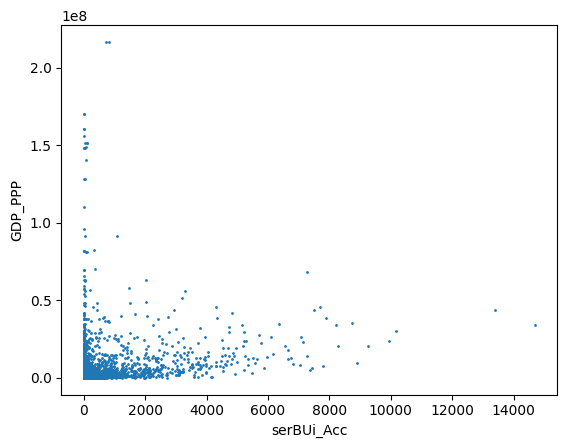

In [71]:
# Link between buildings and GDP
plt.scatter(grid['serBUi_Acc'], grid['GDP_PPP'],s=1)

# Add labels to the plot
plt.xlabel('serBUi_Acc')
plt.ylabel('GDP_PPP')

# Set the axis to logarithmic scale
# plt.yscale('log')
# plt.xscale('log')

# Show the plot
plt.show()

In [72]:
threshold_access = 0.1 # lower value than residential because easier to connect services buildings
alpha = 0
beta = 0
gama = 1

In [73]:
# compute weighted average
# Create a boolean Series indicating if probElec meets the condition
condition_met = grid[probElec] >= threshold_access
# Assign the weighted average based on the condition
grid['SEn_kWh_weighted'] = condition_met * (alpha * grid['SEn_kWh_GDP'] + beta * grid['SEn_kWh_bui'] + gama * grid['SEn_kWh_Emp'] )

totalSEn_kWh_weighted = grid['SEn_kWh_weighted'].sum()
grid['SEn_kWh_final'] = grid['SEn_kWh_weighted'] / totalSEn_kWh_weighted * total_servicesenergy_GWh *10**6 

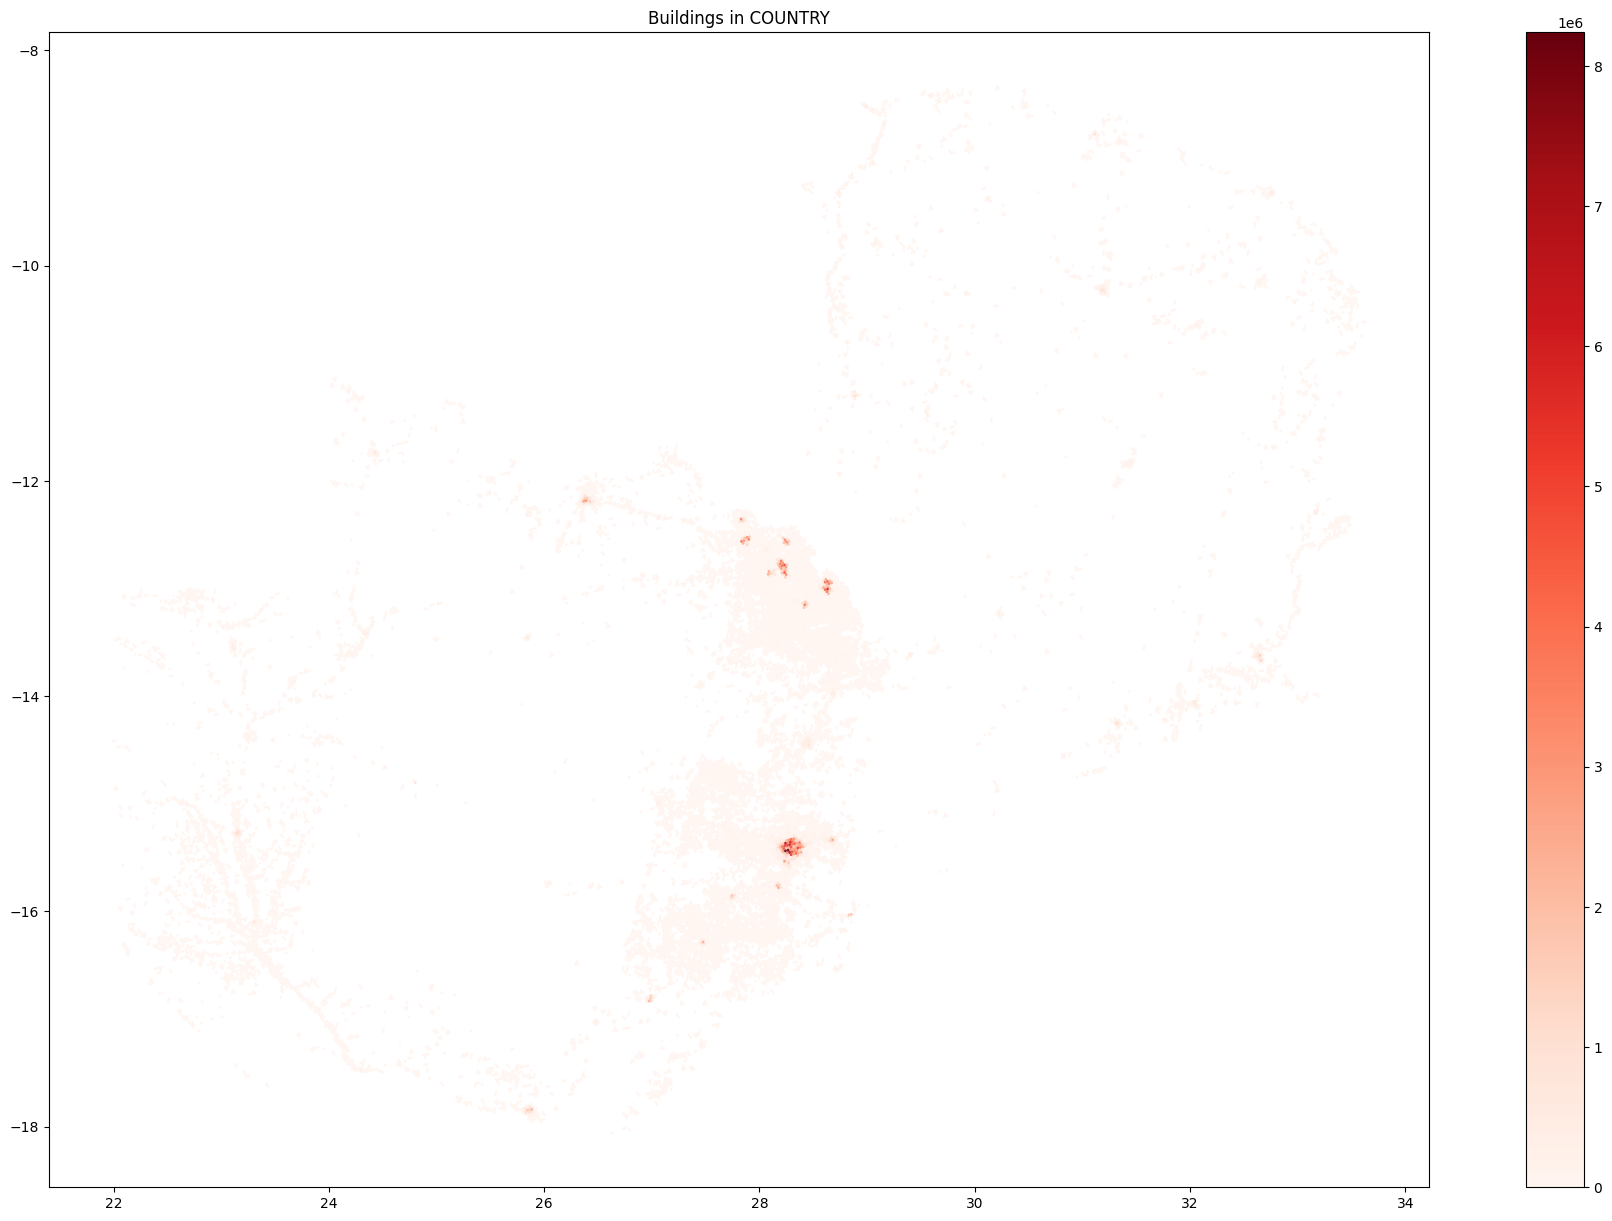

In [74]:
# Plot the energy consumption in services buildings map
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot data
grid.sort_values('SEn_kWh_final', ascending=True).plot(
    ax=ax, column='SEn_kWh_final', cmap="Reds", legend=True, alpha=0.9)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Buildings in {}'.format(area) )

# Save plot as figure 
plt.savefig('services_map' +str(alpha) +str(gama)+'.png', bbox_inches='tight')

In [75]:
grid.to_csv("dataser.csv")
grid.to_file(out_path + "\\" + 'ser_energy_map.shp', index=False)
grid.head(3)

,hexagons,lon,lat,index_righ,NAME_1,id,buildingssum,locationWP,HREA,rwi,...,SEn_kWh_bui,SEn_kWh_GDP,nb_women,nb_women_working,nb_men,nb_men_working,total_employee,SEn_kWh_Emp,SEn_kWh_weighted,SEn_kWh_final
0,87344d185ffffff,27.26,-15.29,0.00,Central,1,42.00,0.00,0.11,-0.59,...,"1,047.79",NaN,24.38,9.46,25.37,816.94,826.40,"1,563.13",NaN,NaN
1,875511689ffffff,22.96,-14.19,9.00,Western,2,121.00,0.00,0.03,-0.43,...,686.07,NaN,83.44,28.45,86.84,"2,457.61","2,486.07","4,702.39",NaN,NaN
2,87344aa90ffffff,26.30,-17.36,8.00,Southern,3,NaN,NaN,0.16,-0.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
total_servicesenergy_scaled = grid.groupby('NAME_1')['SEn_kWh_final'].sum() 
print ("Services electricity consumption assessed after scaling:")
for region in regions:
    total_servicesenergy_scaled[region] = total_servicesenergy_scaled[region]/10**6  # conversion in GWh
    print (region, f"{total_servicesenergy_scaled[region]:,.1f}", "GWh" )
print (total_servicesenergy_scaled )
print (total_servicesenergy_scaled.sum() )

Services electricity consumption assessed after scaling:
Copperbelt 214.1 GWh
Muchinga 8.2 GWh
North-Western 40.2 GWh
Western 16.7 GWh
Luapula 21.8 GWh
Northern 14.5 GWh
Central 43.5 GWh
Southern 52.9 GWh
Eastern 26.9 GWh
Lusaka 282.8 GWh
NAME_1
Central          43.49
Copperbelt      214.13
Eastern          26.86
Luapula          21.81
Lusaka          282.79
Muchinga          8.24
North-Western    40.23
Northern         14.54
Southern         52.88
Western          16.69
Name: SEn_kWh_final, dtype: float64
721.6666666666667


# Buildings

In [77]:
# total_Buienergy_scaled = total_servicesenergy_scaled + total_residentialenergy_scaled
total_Buienergy_scaled = total_servicesenergy_scaled + result_afterscaling['meth3']
print ("Services electricity consumption assessed after scaling:")
for region in regions:
    print (region, f"{total_Buienergy_scaled[region]:,.1f}", "GWh" )
print (total_Buienergy_scaled )

Services electricity consumption assessed after scaling:
Copperbelt 1,510.2 GWh
Muchinga 35.7 GWh
North-Western 214.5 GWh
Western 82.1 GWh
Luapula 57.1 GWh
Northern 119.6 GWh
Central 274.3 GWh
Southern 310.7 GWh
Eastern 146.6 GWh
Lusaka 1,993.5 GWh
NAME_1
Central           274.29
Copperbelt      1,510.22
Eastern           146.59
Luapula            57.06
Lusaka          1,993.47
Muchinga           35.69
North-Western     214.52
Northern          119.58
Southern          310.67
Western            82.08
dtype: float64
